In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 
import matplotlib.gridspec as gridspec

import seaborn as sns

import geopandas as gp
import geoplot
import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [15]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
       
def perform_fa(df, NUM, rotation, method):
    fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
    fa.fit(df)
    return fa

def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    print(stations['factor'].unique())
    df.plot(ax=ax,c=stations['factor'])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/map_4_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load, list_of_factors, station_names, weekend_removed):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)

    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left

    df_scores.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
    ax4.legend(bbox_to_anchor=(1.53, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,len(station_names)))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();

    fig.tight_layout()
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear
  
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
    print(df_scores['week day'].unique())
    df_scores.loc[df_scores['week day']==7,'week day']=0
    print(df_scores['week day'].unique())
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times,weekend_removed):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    
    
    if weekend_removed:
        # If friday and saturday were removed
        plt.xlim([-1,48*5+1])
        plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))
    else:    
        plt.xlim([-1,48*7+1])
        plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))

    plt.xlabel('\nHour in the week')

    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')

    fig.tight_layout()
    plt.show();
    
    
    
def get_FA_results(df, times, NUM, rotation, stations, gdf, weekend_removed, STATIONS_TO_DROP, show_factors):
    
    mpl.style.use('default')
    print(test_if_FA_suitable(df))
    
    # scree plot
    fa = FactorAnalyzer()
    fa.fit(df)
    ev, _ = fa.get_eigenvalues()
    scree_plot(ev,df)
    
    df.drop(STATIONS_TO_DROP,axis=1,inplace=True)
    
    # FA
    fa = perform_fa(df, NUM, rotation, method = 'ml')
    
    # print cummulative variance
    print(fa.get_factor_variance())
    
    # plot loadings 
    Loadings = fa.loadings_
    scores = fa.transform(df) # numerical value, no units
    col_names = df.columns
    loadings_plot(Loadings, col_names)
    
    # plot stations  
    # ascribe a factor to each station based on max loading value (and show it on map)
    stations = stations[stations.name.isin(df.columns)]
    stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
    stations['max_load'] = np.max(abs(Loadings),axis=1)
    plot_map(gdf,stations)
    
    # plot factors and loadings 
    FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
    
    if (show_factors == 'all'): 
        list_of_factors = FACTOR_COLUMNS      
        print('Hi')
    else:
        list_of_factors = show_factors
        
    
    df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
    df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)
    print(df_scores.index)
    print(times.index)
    df_scores = add_group_columns_to_df_scores(df_scores,times)
#     print(df_scores.head())
#     print(df_scores['week day'].unique())

    plot_factors_and_loadings(df_scores,df_load, list_of_factors, df.columns, weekend_removed=weekend_removed)
    
    return Loadings, scores, stations.name


In [24]:
def initialize():
    df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1_fixed_2012_2019.csv")
    times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df_2012_2019.csv")
#     df = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/times_df_2012_2019.csv")
#     times = pd.read_csv("/Users/iditbela/Documents/Broday/sent_from_Yuval/Mon_DataBase/RF_add1_fixed_2012_2019.csv")
    
    df.drop(columns = 'Unnamed: 0',inplace=True)
    times.drop(columns = 'Unnamed: 0',inplace=True)
    times.rename({'0': 'time'}, axis = 'columns',inplace=True)
    
    # NOTE THIS STATION FILE WAS GENERATED FOR 34 STATIONS OF 2013-2018
    stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 
    gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
#     stations = pd.read_csv("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/stations_info.csv") 
#     gdf = gp.read_file("/Users/iditbela/Documents/Broday/GIS/IsraelBorder/IsraelBorder.shp")

    return df,times,stations,gdf

In [25]:
df,times,stations,gdf = initialize()

In [26]:
df.head()
df.shape

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YEFET_YAFO,AHUZA_G,ATZMAUT_B,KIRYAT_ATA,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,21.05,12.1,17.00,14.7,18.1,18.0,20.64,11.6,27.6,16.44,...,9.20,19.7,7.8,11.8,51.60,33.1,13.0,32.6,12.7,20.46
1,20.53,11.4,16.15,11.9,19.0,18.0,19.13,9.7,29.3,17.23,...,12.70,8.2,11.5,14.1,25.07,23.5,13.0,34.1,12.3,15.61
2,20.67,11.6,14.79,12.4,19.0,18.0,20.68,9.5,28.0,15.80,...,11.05,5.9,16.8,5.0,14.51,22.1,13.0,32.4,11.4,15.98
3,17.15,12.3,14.31,11.7,19.0,18.0,20.37,10.1,34.4,15.38,...,14.89,9.1,15.0,2.0,12.95,26.2,13.0,26.8,10.6,18.81
4,19.68,11.4,13.91,12.5,19.0,18.0,19.50,11.8,32.0,17.41,...,17.91,8.5,13.0,40.6,16.63,26.2,13.0,19.4,10.6,15.25


(140256, 33)

In [57]:
y=df.ASHDOD_IGUD.values

In [62]:
# https://stackoverflow.com/questions/51885273/python-why-does-removing-frequencies-using-fft-approach-not-seem-to-have-remove
from scipy.fftpack import fftfreq

# Sampling rate
Fs = 30.0/60.0

#Calculate the anomalies from the mean of time series y
y = y - y.mean()

#Calculate FFT 
fftVar = np.fft.fft(y)

#calculate the frequencies.
#Here 1/Fs is the sampling interval, which is 1 minute (60 seconds)
f = fftfreq(len(y), 1/Fs)

#Remove frequencies not needed 
frqThreshold = 0.1 * Fs

fftVar[(f >= frqThreshold) | (f <= -frqThreshold)] = 0.0

postFFT = np.real(np.fft.ifft(fftVar))


In [63]:
postFFT = pd.DataFrame(data = postFFT, columns=['ASHDOD_IGUD'])

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


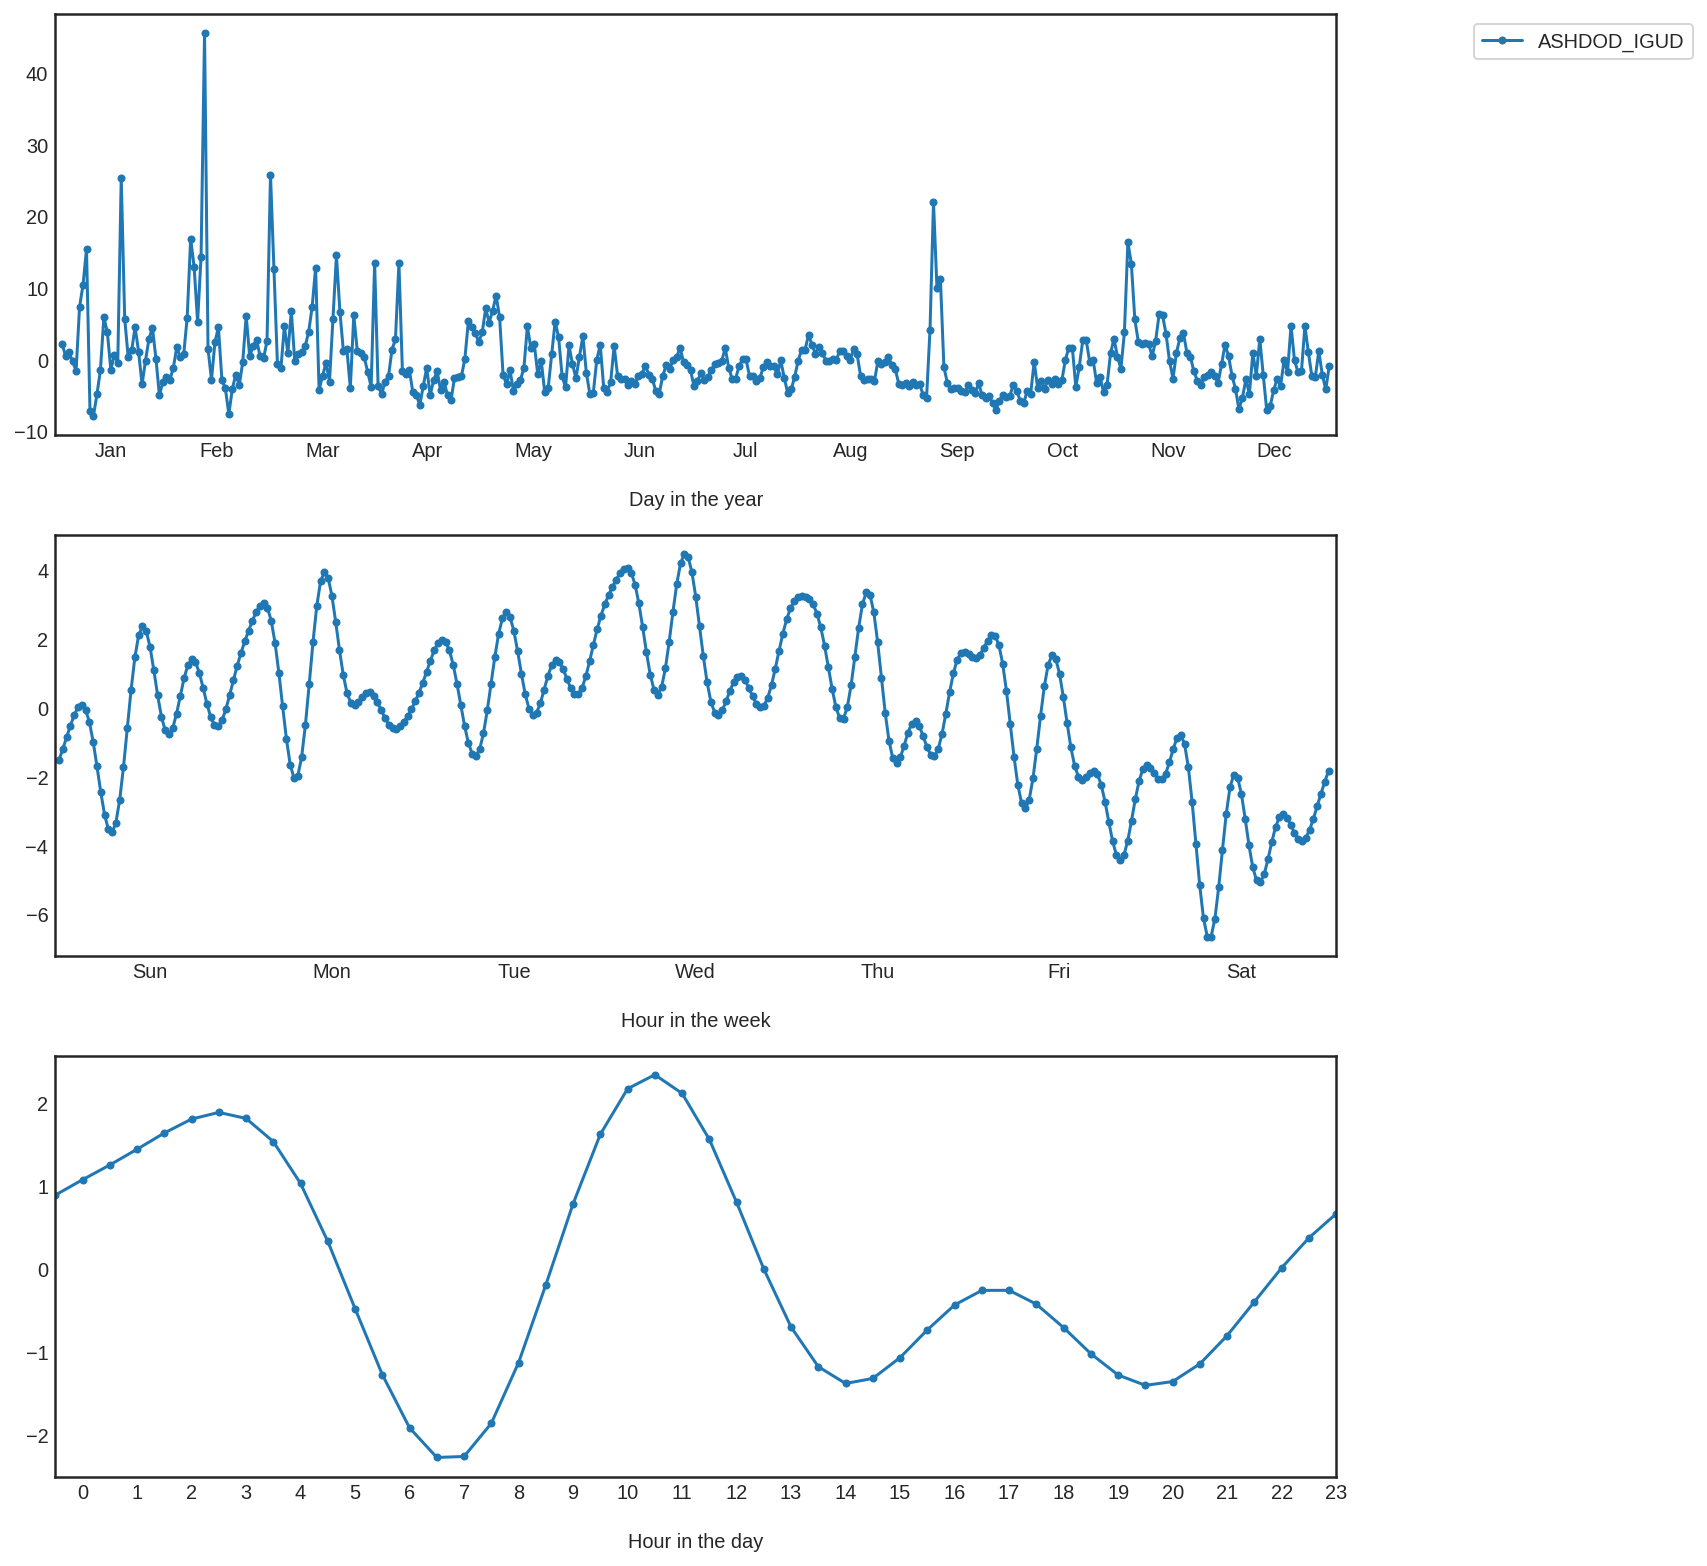

In [64]:
plot_time_series_sections(postFFT,'ASHDOD_IGUD',times,False)

[7 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


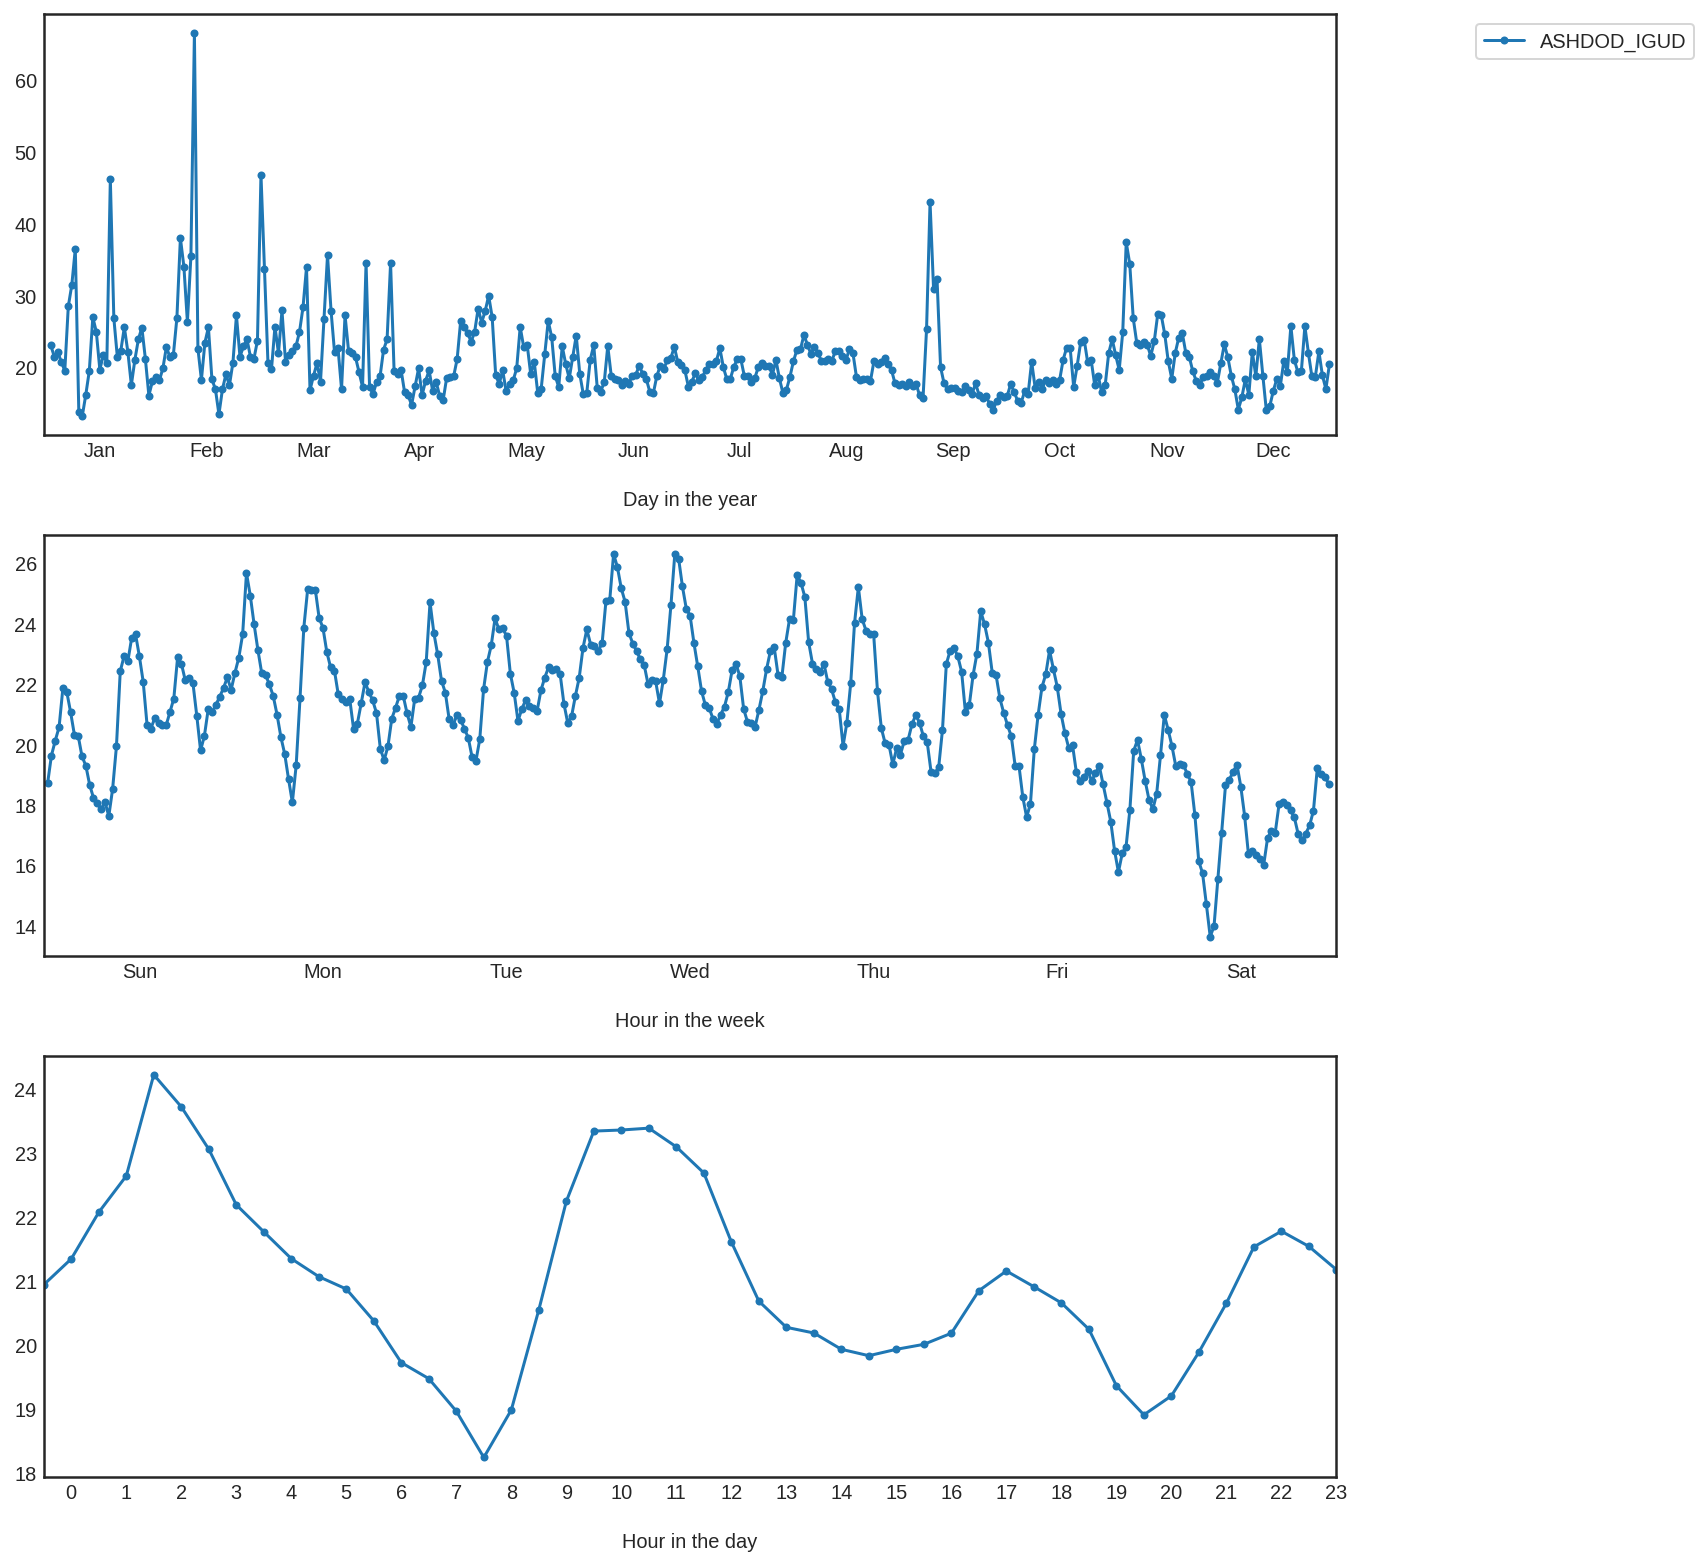

In [61]:
plot_time_series_sections(df,'ASHDOD_IGUD',times,False)

In [ ]:
# MAYBE CHECK - 
# https://cran.r-project.org/web/packages/stR/stR.pdf

In [ ]:
# seasonality
# https://machinelearningmastery.com/time-series-seasonality-with-python/
# trend
# https://machinelearningmastery.com/time-series-trends-in-python/

In [5]:
pm_threshold = 300

In [6]:
times_extreme_removed = times[(df < pm_threshold).all(axis=1)]
df_extreme_removed = df[(df < pm_threshold).all(axis=1)]

In [7]:
df_extreme_removed['week day'] = pd.to_datetime(times['0']).dt.dayofweek

/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
times_extreme_removed = times_extreme_removed[((df_extreme_removed['week day']!=5) & (df_extreme_removed['week day']!=4))]
df_extreme_removed = df_extreme_removed[((df_extreme_removed['week day']!=5) & (df_extreme_removed['week day']!=4))]

In [9]:
df_extreme_removed['week day'].unique()

array([1, 2, 3, 6, 0])

In [10]:
df_extreme_removed.drop(['week day'],axis = 1, inplace =True)

In [11]:
times_extreme_removed.shape
df_extreme_removed.shape

(74639, 1)

(74639, 34)

In [12]:
times_extreme_removed.reset_index(inplace=True,drop=True)
df_extreme_removed.reset_index(inplace=True,drop=True)

In [13]:
# STATIONS_TO_DROP = []
# STATIONS_TO_DROP = ['BEER_SHEVA','BAR_ILAN','EAST_NEGEV','EFRATA','AFULA']
# df_extreme_removed.drop(STATIONS_TO_DROP,axis=1, inplace=True)

In [14]:
NUM = 3
rotation = 'promax' #oblimin, quartimin, promax, varimax=explains more variance. should understand maybe it is better.

In [15]:
fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method= 'ml') 
fa.fit(df_extreme_removed)
Loadings = fa.loadings_
fa.get_factor_variance()
scores = fa.transform(df_extreme_removed) # numerical value, no units

FactorAnalyzer(method='ml', rotation_kwargs={})

(array([6.5358296 , 6.06058127, 5.48839123]),
 array([0.19223028, 0.17825239, 0.16142327]),
 array([0.19223028, 0.37048267, 0.53190594]))

In [16]:
stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 

In [17]:
stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
stations['max_load'] = np.max(abs(Loadings),axis=1)

In [18]:
FACTOR_COLUMNS = ['F'+str(i+1) for i in range(NUM)]
df_load = pd.DataFrame(Loadings,columns=FACTOR_COLUMNS)
df_scores = pd.DataFrame(scores, columns=FACTOR_COLUMNS)

In [19]:
times_extreme_removed.rename({'0': 'time'}, axis = 'columns',inplace=True)

In [20]:
df_scores['datetime'] = pd.to_datetime(times_extreme_removed['time'], format='%Y-%m-%d %H:%M')
df_scores['month'] = pd.to_datetime(times_extreme_removed['time']).dt.month
df_scores['hour'] = pd.to_datetime(times_extreme_removed['time']).dt.hour
df_scores['minute'] = pd.to_datetime(times_extreme_removed['time']).dt.minute
df_scores['Day in year'] = pd.to_datetime(times_extreme_removed['time']).dt.dayofyear

df_scores['week day'] = pd.to_datetime(times_extreme_removed['time']).dt.dayofweek+1
df_scores.loc[df_scores['week day']==7,'week day']=0

In [21]:
df_scores['week day'].unique()

array([2, 3, 4, 0, 1])

In [22]:
list_of_factors = ['F1','F2','F3']

In [23]:
station_names = df_extreme_removed.columns
len(station_names)

34

In [24]:
df_scores.head()

,F1,F2,F3,datetime,month,hour,minute,Day in year,week day
0,1.431381,0.039124,1.630061,2013-01-01 00:00:00,1,0,0,1,2
1,1.427595,0.102169,1.923282,2013-01-01 00:30:00,1,0,30,1,2
2,1.975656,0.232320,1.985985,2013-01-01 01:00:00,1,1,0,1,2
3,2.001439,-0.031109,1.324911,2013-01-01 01:30:00,1,1,30,1,2
4,1.657219,0.213193,0.810898,2013-01-01 02:00:00,1,2,0,1,2


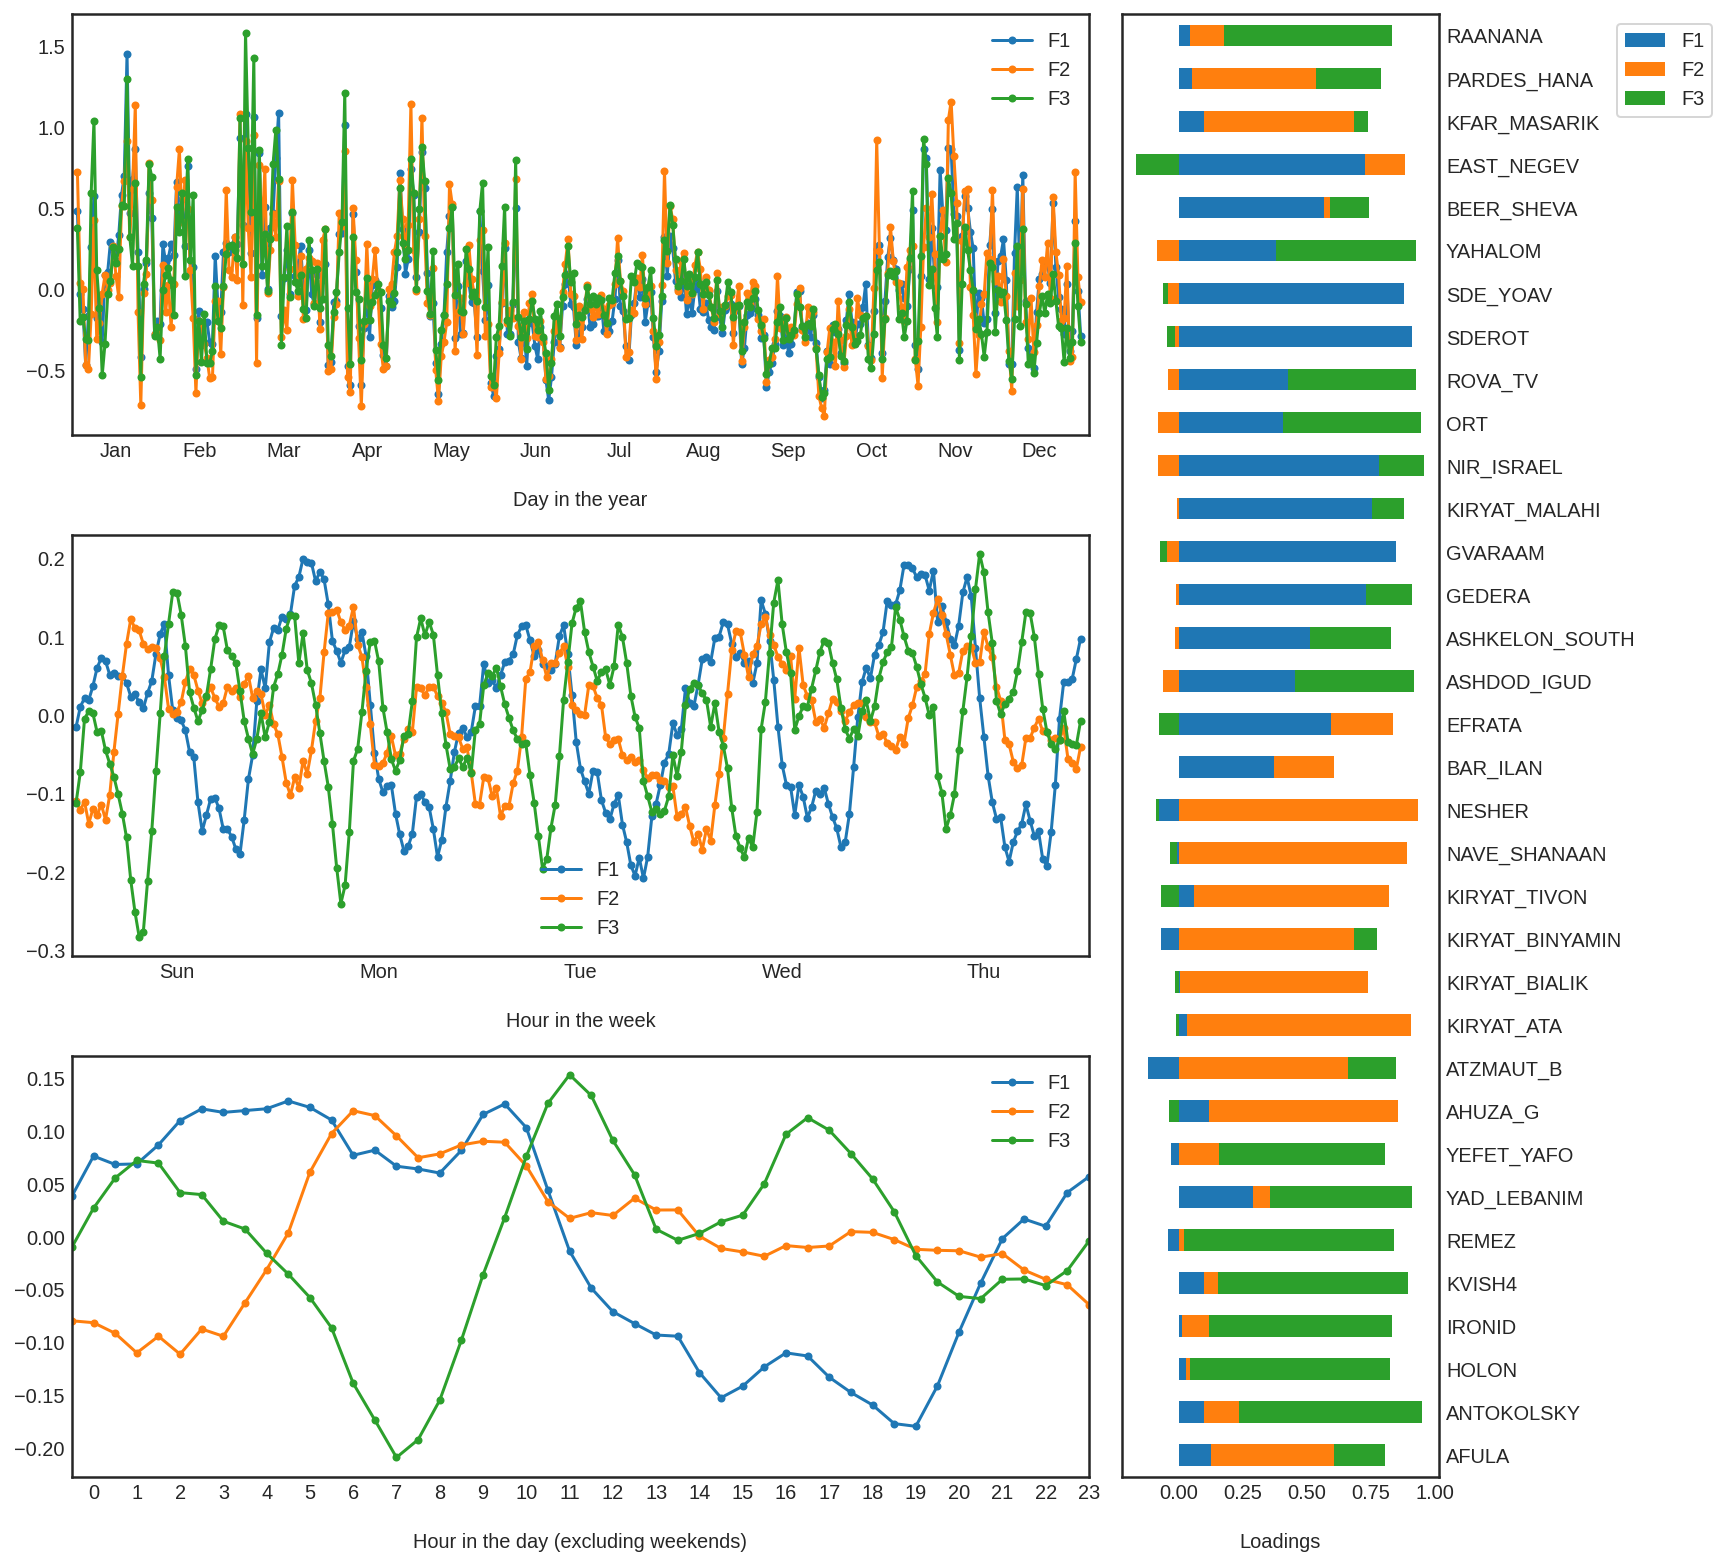

In [25]:
mpl.style.use('seaborn-white')
cm = sns.color_palette(None, len(list_of_factors))
cm

fig = plt.figure(figsize=(12,11))
grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
ax1 = plt.subplot(grid[0,:3])  # top left
df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=True)
# ax1.legend(loc='upper right')
plt.xlim([-1,368])
plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
plt.xlabel('\nDay in the year')

ax2 = plt.subplot(grid[1,:3])   # middle left
df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=True)
plt.xlim([-1,48*5+1])
plt.xticks(np.linspace(24,48*5-24,5), ('Sun', 'Mon','Tue','Wed','Thu'))

plt.xlabel('\nHour in the week')


ax3 = plt.subplot(grid[2,:3])  # bottom left

df_scores.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=True)
plt.xlim([0,47])
plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
plt.xlabel('\nHour in the day (excluding weekends)')

ax4 = plt.subplot(grid[0:3,3:5])  # all right

df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=True)
ax4.legend(bbox_to_anchor=(1.53, 1), loc=2 ,frameon=True)
ax4.set_yticks(np.arange(0,len(station_names)))
ax4.set_yticklabels(station_names)
ax4.yaxis.tick_right()
ax4.set_facecolor('white')
plt.xlabel('\nLoadings')
# plt.show();

fig.tight_layout()
plt.show();


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
c = ax.pcolor(abs(Loadings))
fig.colorbar(c, ax=ax)
ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
ax.set_yticklabels(col_names)
ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
# plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
plt.show();   


In [37]:
np.corrcoef(scores[:,1],scores[:,2])

array([[1.        , 0.69305286],
       [0.69305286, 1.        ]])

In [31]:
# this should equal the communalities. We might want to remove stations that
# not enough variance is accounted for by the chosen factors (=low communalities)
# "A particular set of factors is said to explain a lot of the variance of a variable if it has a high communality"
# "Often times variables with low communalities (less than .20 so that 80% is unique variance) are eliminated from the analysis since the aim of factor analysis is to try and explain the variance through the common factors"
station_names[fa.get_communalities()<0.2]

Index(['BAR_ILAN'], dtype='object')

In [27]:
np.mean(scores)
np.std(scores)

-6.701886225366237e-17

0.9764606011919408

In [28]:
# "communalities" (which represent the fraction of the variance in the observed variable that is accounted for by the factors):

In [29]:
fa.get_communalities() # should be high 

array([0.28779672, 0.54260415, 0.61326166, 0.52657486, 0.56767547,
       0.68065381, 0.39507164, 0.44703723, 0.55738977, 0.48765005,
       0.76275991, 0.54224515, 0.48041412, 0.58997412, 0.79495813,
       0.8774166 , 0.19284806, 0.4171435 , 0.42668792, 0.36333863,
       0.56751304, 0.72557219, 0.58732631, 0.64985502, 0.46544562,
       0.43357706, 0.83543164, 0.77692037, 0.45235223, 0.34473982,
       0.583481  , 0.35704812, 0.30256777, 0.44947038])

In [30]:
fa.get_uniquenesses() # sould be low

array([0.71220328, 0.45739585, 0.38673834, 0.47342514, 0.43232453,
       0.31934619, 0.60492836, 0.55296277, 0.44261023, 0.51234995,
       0.23724009, 0.45775485, 0.51958588, 0.41002588, 0.20504187,
       0.1225834 , 0.80715194, 0.5828565 , 0.57331208, 0.63666137,
       0.43248696, 0.27442781, 0.41267369, 0.35014498, 0.53455438,
       0.56642294, 0.16456836, 0.22307963, 0.54764777, 0.65526018,
       0.416519  , 0.64295188, 0.69743223, 0.55052962])

In [33]:
scores

array([[ 1.43138136,  0.03912408,  1.63006127],
       [ 1.42759539,  0.10216895,  1.92328229],
       [ 1.97565646,  0.23232022,  1.98598472],
       ...,
       [ 0.50356532,  1.21852865, -0.35193817],
       [ 0.55255589,  1.09827404,  0.06912939],
       [ 0.86433615,  1.18891114,  0.18939478]])

In [ ]:
Z1 = 

In [194]:
Loadings[:,0]
Loadings[:,0].reshape(-1,1).shape

array([ 0.12456959,  0.09754067,  0.02698528,  0.01353278,  0.10012181,
       -0.04240779,  0.29127124, -0.02918757,  0.11979365, -0.12000459,
        0.03339426,  0.0028696 , -0.07016284,  0.05833417, -0.00672685,
       -0.07644865,  0.3725281 ,  0.59367505,  0.45307789,  0.51109985,
        0.73083141,  0.85011846,  0.75623927,  0.78182895,  0.40853315,
        0.42690922,  0.91336554,  0.88017191,  0.38172734,  0.56706291,
        0.72876284,  0.0991877 ,  0.04951282,  0.04279258])

(34, 1)

In [193]:
scores[:,0]
scores[:,0].reshape(-1,1).shape

array([1.43138136, 1.42759539, 1.97565646, ..., 0.50356532, 0.55255589,
       0.86433615])

(74639, 1)

In [199]:
Z1 = np.dot(Loadings[:,0].reshape(-1,1),np.transpose(scores[:,0].reshape(-1,1))).T

In [208]:
Z1

array([[0.17830658, 0.1396179 , 0.03862623, ..., 0.14197543, 0.07087172,
        0.06125251],
       [0.17783497, 0.13924861, 0.03852406, ..., 0.14159991, 0.07068427,
        0.06109049],
       [0.24610671, 0.19270686, 0.05331364, ..., 0.19596083, 0.09782031,
        0.08454344],
       ...,
       [0.06272892, 0.0491181 , 0.01358885, ..., 0.04994749, 0.02493294,
        0.02154886],
       [0.06883166, 0.05389667, 0.01491088, ..., 0.05480675, 0.0273586 ,
        0.02364529],
       [0.10767   , 0.08430793, 0.02332435, ..., 0.08573152, 0.04279572,
        0.03698718]])

In [201]:
Z2 = np.dot(Loadings[:,1].reshape(-1,1),np.transpose(scores[:,1].reshape(-1,1))).T

In [211]:
Z2

array([[1.89065995e-02, 5.33879510e-03, 7.10192206e-04, ...,
        2.29539638e-02, 1.89962869e-02, 5.23835007e-03],
       [4.93728598e-02, 1.39417764e-02, 1.85460216e-03, ...,
        5.99421824e-02, 4.96070704e-02, 1.36794733e-02],
       [1.12268095e-01, 3.17019649e-02, 4.21714787e-03, ...,
        1.36301495e-01, 1.12800662e-01, 3.11055186e-02],
       ...,
       [5.88850549e-01, 1.66278046e-01, 2.21191056e-02, ...,
        7.14906675e-01, 5.91643886e-01, 1.63149662e-01],
       [5.30737847e-01, 1.49868336e-01, 1.99362070e-02, ...,
        6.44353698e-01, 5.33255513e-01, 1.47048687e-01],
       [5.74537971e-01, 1.62236498e-01, 2.15814794e-02, ...,
        6.97530181e-01, 5.77263412e-01, 1.59184152e-01]])

In [203]:
Z3 = np.dot(Loadings[:,2].reshape(-1,1),np.transpose(scores[:,2].reshape(-1,1))).T

In [204]:
Z3

array([[ 0.32088322,  1.169186  ,  1.27541639, ...,  0.08923693,
         0.413559  ,  1.06854521],
       [ 0.37860479,  1.37950319,  1.50484266, ...,  0.10528917,
         0.48795141,  1.26075879],
       [ 0.39094799,  1.42447746,  1.55390322, ...,  0.10872179,
         0.5038595 ,  1.30186178],
       ...,
       [-0.06928025, -0.25243295, -0.27536861, ..., -0.01926669,
        -0.0892894 , -0.23070412],
       [ 0.01360836,  0.0495841 ,  0.05408923, ...,  0.00378446,
         0.01753866,  0.04531602],
       [ 0.03728302,  0.13584626,  0.14818903, ...,  0.01036833,
         0.0480509 ,  0.12415293]])

array([0.71220328, 0.45739585, 0.38673834, 0.47342514, 0.43232453,
       0.31934619, 0.60492836, 0.55296277, 0.44261023, 0.51234995,
       0.23724009, 0.45775485, 0.51958588, 0.41002588, 0.20504187,
       0.1225834 , 0.80715194, 0.5828565 , 0.57331208, 0.63666137,
       0.43248696, 0.27442781, 0.41267369, 0.35014498, 0.53455438,
       0.56642294, 0.16456836, 0.22307963, 0.54764777, 0.65526018,
       0.416519  , 0.64295188, 0.69743223, 0.55052962])

In [170]:
len(mat)

74639

In [177]:
df_extreme_removed.values

array([[27.45, 28.1 , 55.  , ...,  9.3 , 16.9 , 29.4 ],
       [24.02, 26.67, 55.  , ..., 15.6 , 16.9 , 26.73],
       [29.18, 27.7 , 55.  , ..., 20.2 , 11.9 , 38.69],
       ...,
       [26.3 , 28.5 , 21.8 , ..., 19.4 , 37.6 , 18.6 ],
       [22.7 , 29.3 , 24.1 , ..., 26.8 , 33.  , 25.88],
       [13.3 , 27.2 , 45.  , ..., 25.85, 33.4 , 49.8 ]])

In [178]:
vec = np.mean(df_extreme_removed.values,axis = 0)
vec
vec_std = np.std(df_extreme_removed.values,axis = 0)

array([19.31406061, 18.7987457 , 19.41762818, 20.01135506, 22.34707392,
       22.20868621, 19.30438015, 21.60248811, 16.69683825, 19.63176744,
       16.33798966, 15.74040153, 18.95084929, 17.16219255, 13.5821044 ,
       13.98087247, 20.1131848 , 18.07536596, 20.64048714, 17.98864655,
       19.35949999, 18.69361366, 19.67391913, 17.70238575, 19.15367422,
       18.79844773, 19.97377725, 18.79602808, 19.54827583, 19.42039055,
       18.8568412 , 19.75725438, 20.10605809, 19.7148468 ])

In [179]:
for i in range(len(mat)):
    mat[i,:] = mat[i,:]*vec_std+vec

In [180]:
mat

array([[261.57423746, 254.66593023, 301.7951416 , ..., 261.54575055,
        253.72828744, 282.34039072],
       [262.64573698, 257.22891275, 304.93415043, ..., 262.18207604,
        254.91644361, 284.86580066],
       [264.39878878, 258.59152387, 305.83597516, ..., 263.80298121,
        256.12071894, 285.89844737],
       ...,
       [262.3585085 , 238.82042364, 280.62384396, ..., 267.48335902,
        253.99876107, 267.46396621],
       [262.73570731, 242.22582754, 285.09937407, ..., 266.96812909,
        254.57535363, 270.76431987],
       [264.03437771, 243.73911956, 286.51802603, ..., 268.06383437,
        255.5950791 , 272.07826443]])